# Tobig's 정규세션 10주차 음성 과제 1

- 다음 5개의 질문에 **단답형**으로 답해주세요.

## Q1. 시간에 따른 소리의 진폭을 나타낸 그래프를 영어로 무엇이라고 하나요?

A1. waveform

## Q2. 샘플링 주파수는 원래 신호의 최고 주파수의 2배 이상이 되어야 원래 신호로 복구할 수 있다는 정리의 이름을 영어로 무엇이라고 하나요?

A2. Nyquist-Shannon Sampling Theorum

## Q3. 소리를 시각화한 것으로, 단시간 푸리에 변환을 통해 시간, 주파수, 진폭 정보를 모두 담고 있는 것을 영어로 무엇이라고 하나요?

A3. Spectogram

## Q4. 인간의 청각 시스템에 맞게 Mel-scale을 적용하여 주파수를 조절한 스펙트로그램을 영어로 무엇이라고 하나요?

A4. Mel-spectogram

## Q5. Speech 정규세션 강의자가 수업 시작할 때 5명을 랜덤으로 지목하여 질문하겠다고 했으나, 실제로는 그보다 적은 n명에게 질문하였습니다. n의 값은 무엇입니까?

A5. 0

# Tobig's 정규세션 10주차 음성 과제 2

1. train 폴더 내의 2,000개 음원을 이용하여 음성 분류 모델을 만들어보세요.
2. 음성 분류 모델을 이용하여 test 폴더 내의 300개 음원을 분류하세요.

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch

데이터 시각화

In [14]:
# train 파일 불러오기
audio_paths = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]   
for i, path in enumerate(audio_paths):
        # 오디오 파일 로드
    y, sr = librosa.load(path, sr=None)

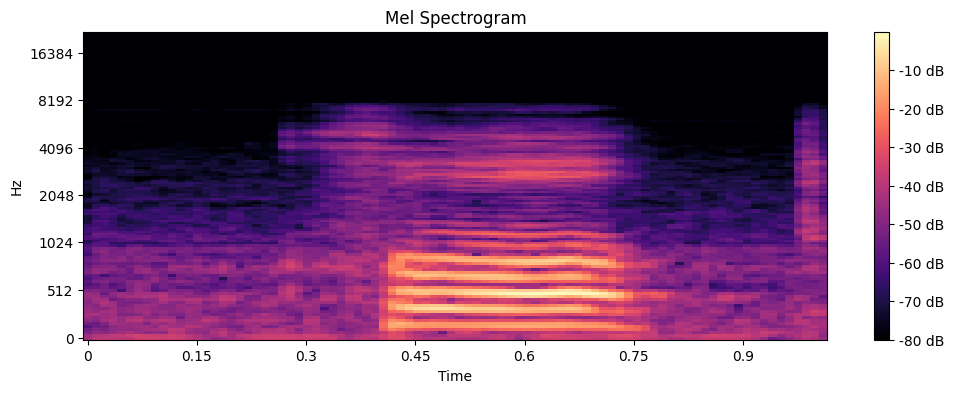

In [15]:
# 멜 스펙트로그램 추출
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# 멜 스펙트로그램 시각화
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.show()

데이터 전처리

In [2]:
def extract_features(file_name, max_length=2, sr=44100, n_mels=128, hop_length=1024):
    """
    Extracts 128-dimensional mel-spectrogram features from an audio file,
    ensuring the output is of a fixed size, with an increased hop_length to reduce time dimension.
    """
    try:
        audio, sample_rate = librosa.load(file_name, sr=sr, duration=max_length, res_type='kaiser_fast')
        audio = librosa.util.fix_length(audio, size=max_length*sample_rate)
        
        # mel-spectrogram 생성
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, hop_length=hop_length)
        db_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # spectrogram 크기 고정
        fixed_spectrogram = db_mel_spectrogram
        
        return fixed_spectrogram
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, error: {e}")
        return None


In [3]:
def load_data(data_dir):
    """
    Traverse through the directory, extract features for each audio file,
    and return arrays of features and labels.
    """
    features = []
    labels = []
    
    # 폴더 내 모든 파일 불러오기!
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        
        # 라벨 추출
        label = int(file_path.split('/')[-1][-5])
        data = extract_features(file_path)
        
        if data is not None:
            features.append(data)
            labels.append(label)
    
    return np.array(features), np.array(labels)


In [1]:
pip install --upgrade librosa numba

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Paths to your data directories
train_data_dir = 'train'
test_data_dir = 'test'

# Loading training and test data
X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)  # y_test 는 라벨 포함X


In [5]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)

print("X_train dtype: ", X_train.dtype)
print("y_train dtype: ", y_train.dtype)
print("X_test dtype: ", X_test.dtype)

X_train shape:  (2000, 128, 87)
y_train shape:  (2000,)
X_test shape:  (300, 128, 87)
X_train dtype:  float32
y_train dtype:  int32
X_test dtype:  float32


In [6]:
# 모델으로의 입력을 위해 데이터 차원 수정
# 음성 데이터의 차원을 (N, C, H, W) 형태로 맞추는 과정 - C=1 추가
X_train_tensor = torch.tensor(X_train).unsqueeze(1)  # 채널 차원 추가
X_test_tensor = torch.tensor(X_test).unsqueeze(1)    # 채널 차원 추가

print("New X_train shape:", X_train_tensor.shape)  # 새로운 형태 확인
print("New X_test shape:", X_test_tensor.shape)

New X_train shape: torch.Size([2000, 1, 128, 87])
New X_test shape: torch.Size([300, 1, 128, 87])


분류 모델 설계 - CNN 아키텍처

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# (N, C, H, W)
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 10, 512)  #마지막 pooling layer 거친 후의 차원 확인 결과 적용
        #self.fc1 = nn.Linear(1, 512)  # 평탄화된 텐서 크기에 맞게 조정

        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(x.size(0), -1)  # x.size(0)는 배치 크기를 유지하고, 나머지는 평탄화

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# 데이터 로드
from torch.utils.data import DataLoader, TensorDataset
import torch

# 데이터를 PyTorch 텐서로 변환
# X_test, X_train은 앞서 모델 입력 형태로 adjust된 상태.
y_train_tensor = torch.tensor(y_train).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

모델 학습

In [26]:
import torch.optim as optim

model = AudioCNN()

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs.shape
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/30, Loss: 2.624403094488477
Epoch 2/30, Loss: 1.2004141618335058
Epoch 3/30, Loss: 0.9076120702047197
Epoch 4/30, Loss: 0.720199325728038
Epoch 5/30, Loss: 0.6030606722074842
Epoch 6/30, Loss: 0.44108800613690935
Epoch 7/30, Loss: 0.3723484974295374
Epoch 8/30, Loss: 0.2890642090804047
Epoch 9/30, Loss: 0.2034929282963276
Epoch 10/30, Loss: 0.16039836788106532
Epoch 11/30, Loss: 0.15347844202603614
Epoch 12/30, Loss: 0.120263156510653
Epoch 13/30, Loss: 0.06306366359312383
Epoch 14/30, Loss: 0.02210970438225934
Epoch 15/30, Loss: 0.03133017239752152
Epoch 16/30, Loss: 0.04440752449371512
Epoch 17/30, Loss: 0.08490019258377808
Epoch 18/30, Loss: 0.060955003894392464
Epoch 19/30, Loss: 0.06937653075401036
Epoch 20/30, Loss: 0.09143967520342106
Epoch 21/30, Loss: 0.08875775763705845
Epoch 22/30, Loss: 0.048832592197753016
Epoch 23/30, Loss: 0.03516986495852175
Epoch 24/30, Loss: 0.015027067965425049
Epoch 25/30, Loss: 0.056269279831284956
Epoch 26/30, Loss: 0.025774048127618337
Ep

In [27]:
def test_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)  # test_loader는 데이터만 포함, label X
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
    return all_predictions

# 테스트 모델 실행
predictions = test_model(model, test_loader, device)

# 예측 결과 출력
print(predictions)

[7, 1, 8, 2, 8, 1, 8, 2, 8, 4, 5, 9, 0, 4, 5, 2, 3, 5, 3, 6, 0, 1, 8, 7, 4, 7, 1, 3, 5, 2, 6, 6, 2, 3, 9, 7, 7, 5, 7, 2, 3, 7, 0, 9, 3, 6, 9, 9, 9, 5, 9, 5, 7, 4, 9, 6, 6, 9, 6, 7, 6, 2, 7, 7, 2, 4, 0, 7, 6, 6, 3, 0, 3, 5, 3, 5, 4, 7, 5, 9, 4, 5, 7, 1, 3, 8, 2, 1, 7, 8, 0, 2, 5, 5, 3, 1, 4, 7, 2, 4, 2, 7, 3, 1, 2, 3, 9, 6, 9, 3, 2, 6, 6, 7, 6, 5, 9, 9, 2, 2, 0, 1, 7, 3, 1, 3, 5, 3, 6, 6, 2, 3, 0, 3, 3, 0, 2, 7, 3, 0, 0, 3, 3, 0, 2, 9, 6, 2, 6, 5, 5, 5, 5, 6, 3, 3, 1, 3, 8, 2, 3, 2, 3, 1, 8, 6, 2, 7, 6, 4, 3, 4, 7, 3, 7, 6, 3, 6, 9, 0, 8, 2, 3, 8, 9, 0, 7, 8, 4, 1, 9, 5, 2, 5, 1, 0, 1, 9, 0, 7, 1, 5, 7, 3, 8, 3, 4, 1, 8, 7, 9, 3, 0, 7, 0, 2, 1, 5, 4, 0, 8, 7, 1, 4, 5, 9, 3, 4, 8, 8, 4, 1, 6, 7, 5, 0, 9, 6, 4, 4, 7, 2, 2, 4, 6, 8, 6, 6, 8, 0, 8, 7, 6, 9, 4, 4, 4, 4, 9, 2, 8, 4, 4, 3, 4, 9, 8, 4, 8, 4, 7, 4, 5, 3, 4, 5, 3, 8, 5, 8, 5, 9, 1, 5, 1, 5, 5, 5, 5, 1, 8, 9, 9, 6, 2, 2, 2, 8, 2, 9]
